### Setup

In [1]:
from neuron import h
from cell_inference.config import params, paths
import pandas as pd

h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD_OBLIQUE, index_col='id')
h.dt = params.DT

h.tstop = 200.

### Setup smiulation parameters

In [2]:
import numpy as np
import json

# Biophysical parameters
filepath = './cell_inference/resources/biophys_parameters/neuronal_model_491766131.json'
f = open(filepath)
biophys_param = json.load(f)
f.close()

In [3]:
# (soma,dend,apic,axon) [0.000119174, 0.000095700, 0.00041148, 0.00147346]
biophys = np.array([0.000119174, 0.000095700, 0.00041148, 0.00147346])*(1) # scale g_pas
# biophys = np.array([0.00012, 0.0001, 0.0004, 0.0015]) # fix g_pas
biophys_comm = {} #{'cm': 3.05}

# (soma r,trunk l,trunk r,basal r,tuft r,dend l,axon r,oblique l), bounds([3,12],[20,800],[0.6,2.5],[0.1,0.8],[0.1,0.8],[100,300])
geo_param = [7., 400., .6, .42, .2, 150., .2, .2, 100.] # [7., 500., .25, .2, .2, 200., .18] [7., 400., .45, .48, .35, 150., .2, 100.]
loc_param = [0., 350., 80., 0.0, 1.0, 0.] # position (x,y,z,alpha,h,phi)

In [4]:
ncell = 1
biophys = np.tile(biophys,(ncell,1)) 
# biophys[:,0] = np.linspace(0.00035,0.00045,ncell)
biophys = np.append(biophys,biophys[[0],:],axis=0)
print(biophys)

[[1.19174e-04 9.57000e-05 4.11480e-04 1.47346e-03]
 [1.19174e-04 9.57000e-05 4.11480e-04 1.47346e-03]]


In [5]:
geo_param = np.tile(geo_param,(ncell,1))
# geo_param[:,2] = np.linspace(.56,.6,ncell)
# geo_param[:,[2,3,4,6]] *= 1.0 # scale radius
geo_param = np.append(geo_param,geo_param[[0],:],axis=0)
print(geo_param)

[[7.0e+00 4.0e+02 6.0e-01 4.2e-01 2.0e-01 1.5e+02 2.0e-01 2.0e-01 1.0e+02]
 [7.0e+00 4.0e+02 6.0e-01 4.2e-01 2.0e-01 1.5e+02 2.0e-01 2.0e-01 1.0e+02]]


In [6]:
gmax = [0.]*ncell + [0.02]
ncell += 1

In [7]:
from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes

sim = Simulation(geometry = geo_standard,
                 full_biophys = biophys_param,
                 cell_type = CellTypes.ACTIVE_FULL,
                 biophys = biophys,
                 biophys_comm = biophys_comm,
                 loc_param = loc_param,
                 geo_param = geo_param,
                 gmax = gmax,
                 stim_param = {'start': 5.},
                 scale = 1.,
                 ncell = ncell)

#### Add current injection

In [8]:
for cell in sim.cells[:-1]:
    cell.add_injection(sec_index=0, pulse=True, amp=-0.010, delay=50.0, dur=150.0)

#### Record axial current

In [9]:
from cell_inference.utils.currents.somaaxialcurrent import Soma_Axial_Current

# ac_idx = [0]
ac_idx = [0,-1]
axial_current = [Soma_Axial_Current(sim.cells[i].soma,single_seg=True) for i in ac_idx]

### Show Morphology

In [10]:
# from cell_inference.utils.plotting.plot_morphology import plot_morphology
# %matplotlib notebook

# _ = plot_morphology(sim, figsize=(8,6))

### Simulation results

In [11]:
sim.run_neuron_sim()
# lfp = sim.get_lfp().T
t = sim.t()
v = sim.v('all')

#### Membrane voltage

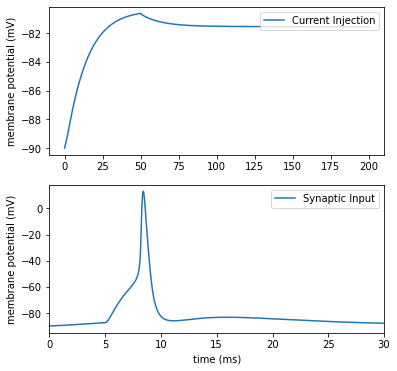

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6,6))
plt.subplot(211)
plt.plot(t,v[0],label='Current Injection')
plt.ylabel('membrane potential (mV)');
plt.legend(loc=1)
plt.subplot(212)
plt.plot(t,v[-1],label='Synaptic Input')
plt.ylabel('membrane potential (mV)');
plt.legend(loc=1)
plt.xlabel('time (ms)')
plt.xlim([0,30])
plt.show()

#### Calculate passive properties

(-80.63407521108667, 92.68834227889187, 12.750000000002899)


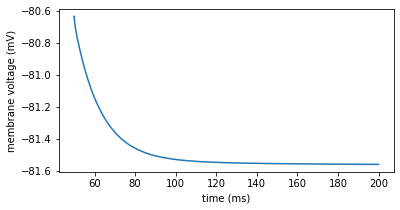

In [13]:
from cell_inference.utils.metrics.measure_passive_properties import measure_passive_properties
%matplotlib inline

plt.figure(figsize=(6,3*(ncell-1)))
for i in range(ncell-1):
    plt.subplot(ncell-1,1,i+1)
    Vrest, Rin, Tau = measure_passive_properties(v[i],t,sim.cells[i].injection[0].pp_obj,ax=plt.gca())
    print((Vrest, Rin, Tau))

#### Axial currents

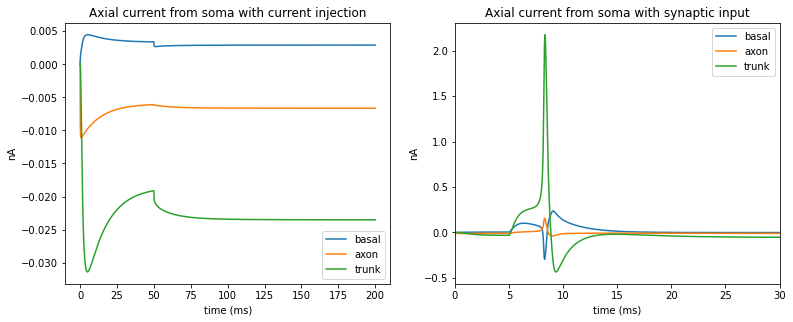

In [14]:
dend_types = axial_current[0].dend_type

plt.figure(figsize=(12.8, 4.8))
for i,AC in enumerate(axial_current):
    plt.subplot(1,2,i+1)
    ac = AC.get_current()
    for dend_type in dend_types:
        plt.plot(t,ac[dend_type].ravel(),label=dend_type)
    plt.ylabel('nA')
    plt.legend()
    if i==len(axial_current)-1:
        plt.title('Axial current from soma with synaptic input')
        plt.xlim([0,30])
    else:
        plt.title('Axial current from soma with current injection')
    plt.xlabel('time (ms)')
plt.show()